# Laboratorio di Simulazione Numerica: lezione 8

Elia Steve, 47122A

In [306]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp

## Esercizio 8.1

In questo esercizio dobbiamo scrivere del codice che permetta di campionare la distributione di probabilità 
$$\frac{|\psi(x)|^2}{\int|\psi(x)|^2dx}$$ associata alla funzione d'onda (in 1D, non normalizzata)

$$
\psi(x) = e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$
per valori fissati di $\mu$ e $\sigma$, e usare questo codice per calcolare il valor medio dell'hamiltoniana

$$
H = -\frac{\partial_x^2}{2} + x^4 - \frac{5}{2}x^2
$$

su questo stato, ovvero

$$
\langle {H} \rangle = \int \frac{|\psi(x)|^2}{\int |\psi(x)|^2 dx} \frac{{\hat H} \psi(x)}{\psi(x)} dx,
$$

vale a dire il valor medio sulla distribuzione di probabilità definita da $|\psi|^2$ dell'_energia locale_ $\frac{{\hat H} \psi(x)}{\psi(x)}$.

La normalizzazione della funzione d'onda (che non mi servirà nel calcolo Monte Carlo perché l'algoritmo di Metropolis permette di campionare distribuzioni di probabilità senza conoscerne la normalizzazione, ma che userò per calcolare l'energia via quadrature per testare il mio codice) è

$$
\int|\psi(x)|^2dx = 2\sqrt{\pi}\sigma\bigg(1+\exp\frac{\mu^2}{\sigma^2}\bigg)
$$

e il laplaciano della funzione d'onda

$$
\partial_x^2\psi = \frac{1}{\sigma^2}\Bigg[e^{-\frac{(x-\mu)^2}{2\sigma^2}}\Bigg(\bigg(\frac{x-\mu}{\sigma}\bigg)^2-1\Bigg) + e^{-\frac{(x+\mu)^2}{2\sigma^2}}\Bigg(\bigg(\frac{x+\mu}{\sigma}\bigg)^2-1\Bigg)\Bigg]
$$

#### Energia locale stabile

La parte cinetica dell'energia locale è

$$\frac{\partial_x^2\psi}{2\psi} = -\frac{1}{2\sigma^2}\frac{
e^{-\frac{(x-\mu)^2}{2\sigma^2}}\Bigg(\bigg(\frac{x-\mu}{\sigma}\bigg)^2-1\Bigg) + e^{-\frac{(x+\mu)^2}{2\sigma^2}}\Bigg(\bigg(\frac{x+\mu}{\sigma}\bigg)^2-1\Bigg)
}{
e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
},$$

o, definendo

$$A_± = \Big(\frac{x±\mu}{\sigma}\Big)^2,$$


$$\frac{\partial_x^2\psi}{2\psi} = -\frac{1}{2\sigma^2}\Bigg[\frac{
e^{-A_-/2}}{e^{-A_-/2}+e^{-A_+/2}}(A_--1) + \frac{e^{-A_+/2}}{{e^{-A_-/2}+e^{-A_+/2}}}(A_+-1)\Bigg].
$$

In questa forma, però, il calcolo di

$$P_± = \frac{e^{-A_±/2}}{e^{-A_-/2}+e^{-A_+/2}}$$

può risentire di problemi di underflow negli esponenziali quando $A_±$ diventa grande (questo in realtà probabilmente non sarebbe stato un problema nei miei calcoli, ma ho apportato questa modifica mentre cercavo di risolvere il bug dell'"energia cinetica negativa", vedi sotto, e l'ho mantenuta nel codice definitivo). Ho quindi calcolato questi valori nel dominio del logaritmo, con il "trucco di logsumexp": definito

$$A = \max\{-A_+/2, -A_-/2\}$$

un'espressione numericamente stabile per il logaritmo di $P_±$ è

$$\log P_± =-A_±/2 - A - \log\bigg[\sum_{i=±}\exp(-A_i/2-A)\bigg]. $$

#### Campionamento della funzione d'onda e calcolo dell'energia

Come al solito usiamo l'algoritmo di Metropolis per campionare la funzione d'onda e calcolare l'energia. Qualche commento:

* il punto iniziale del campionamento va scelto sotto una delle due "campane" della funzione d'onda. Una versione precedente del codice lo sceglieva casualmente con il risultato che quando $\sigma$ diventava piccolo, e quindi le "campane" si stringevano molto, l'algoritmo non riusciva a proporre mosse che risultasero in un valore "sotto la campana": veniva quindi campionata solo la regione all'esterno, dove l'energia cinetica locale è negativa, con il risultato di produrre un valore medio dell'energia cinetica negativo.
* Quando le "campane" si stringono molto, è difficile che il campionamento possa avvenire su entrambe le campane se le mosse vengono proposte solo da una distribuzione uniforme, con larghezza scelta in modo che la probabilità di accettazione sia circa $50\%$. Per mitigare questo problema, ogni $N_\mathrm{flip}$ (io ho usato $N_\mathrm{flip}=30$) iterazioni viene proposta una mossa che partendo da $x$ produce $-x$: dato che la funzione d'onda è pari questa mossa viene accettata con probabilità $1$.
* La larghezza della distribuzione uniforme per la proposta delle mosse dipende dai parametri $\mu$ e $\sigma$ e quindi non può essere fissata a priori: viene determinata dinamicamente durante la fase di equilibrazione in modo che la probabilità di accettazione sia circa $50\%$.

#### Test del calcolo dell'energia

Definisco funzioni per calcolare il modulo quadro della $\psi$, l'energia locale (naive e stabile):

In [307]:
def psi2(x, mu, sigma):
    """
    Modulus squared of wavefunction

    Args:
        x: argument of the wavefunction
        mu, sigma: parameters of the wavefunction

    Returns:
        Modulus squared of wavefunction calculated at x with parameters mu, sigma
    """
    return (np.exp(-(x-mu)**2/(2*sigma**2)) + np.exp(-(x+mu)**2/(2*sigma**2)))**2

def local_energy(x, mu, sigma):
    """
    Local energy computed naively (i. e. not in the log domain)

    Args:
        x: argument of the local energy
        mu, sigma: parameters of the local energy

    Returns:
        Local energy calculated at x with parameters mu, sigma
    """
    V = x**4 - 5/2*x**2
    argplus = (x+mu)/sigma
    argminus = (x-mu)/sigma
    #print(x, argplus, argminus)
    psi = np.exp(-0.5*argminus**2) + np.exp(-0.5*argplus**2)
    lapl_psi = ( np.exp(-argminus**2/2)*(argminus**2-1) + np.exp(-argplus**2/2)*(argplus**2-1) )/sigma**2
    return -0.5*lapl_psi/psi + V

def stable_local_energy(x, mu, sigma):
    """
    Stable local energy, computed in the log domain using the logsumexp trick

    Args:
        x: argument of the local energy
        mu, sigma: parameters of the local energy

    Returns:
        Local energy calculated at x with parameters mu, sigma
    """
    V = x**4 - 5/2*x**2
    argplus = ((x+mu)/sigma)**2
    argminus = ((x-mu)/sigma)**2
    argmax = np.max((-0.5*argplus, -0.5*argminus))
    sumexp = np.exp(-argplus/2 - argmax) + np.exp(-argminus/2 - argmax)
    logprobplus = -argplus/2  - argmax - np.log(sumexp)
    logprobminus = -argminus/2 - argmax - np.log(sumexp)
    K = -(np.exp(logprobplus) * (argplus-1) + np.exp(logprobminus) * (argminus-1))/(2*sigma**2)
    return K+V

Leggo i dati relativi al calcolo dell'energia:

In [308]:
mu, sigma, actual_energy, acten_err, stable_energy, stable_err = np.loadtxt("energy_test.dat", max_rows=1, skiprows=1)
mu, sigma

(1.0, 0.5)

Confronto i risultati ottenuti via Monte Carlo (con entrambe le versioni dell'energia) e quelli ottenuti per quadrature, con SciPy:

In [309]:
#To normalize the exact function
norm = 2*np.sqrt(np.pi)*sigma*(1+np.exp(-(mu/sigma)**2))

In [310]:
#The bounds are ±20 since when they are set to ±inf there is an underflow problem in the energy.
#This does not happen with the stable version, and comparison with that restul shows that the approximate
#version of the bounds is entirely adequate.
unnormalized_E = sp.integrate.quad(lambda x: psi2(x, mu, sigma)*local_energy(x, mu, sigma), -20, 20)

In [311]:
print("Energia locale naive:")
print("Monte Carlo: E =", actual_energy, "±", acten_err)
print("Quadrature: E =", unnormalized_E[0]/norm, "±", unnormalized_E[1]/norm)

Energia locale naive:
Monte Carlo: E = -0.142747 ± 0.00410487
Quadrature: E = -0.1460250222251638 ± 6.419768336573469e-09


In [312]:
unnormalized_E = sp.integrate.quad(lambda x: psi2(x, mu, sigma)*stable_local_energy(x, mu, sigma), -np.inf, np.inf)

In [313]:
print("Energia locale stabile:")
print("Monte Carlo: E =", stable_energy, "±", stable_err)
print("Quadrature: E =", unnormalized_E[0]/norm, "+-", unnormalized_E[1]/norm)

Energia locale stabile:
Monte Carlo: E = -0.140538 ± 0.00463061
Quadrature: E = -0.14602502222516395 +- 5.7052963196135035e-09


Osserivamo che:

* Per entrambe le versioni dell'energia il risultato ottenuto via Monte Carlo è compatibile con quello ottenuto per quadrature.
* Per entrambi i metodi, il valore ottenuto con l'energia naive è compatibile con quello ottenuto con l'energia stabile, e nel caso delle quadrature la compatibilità è eccellente

## Esercizio 8.2

In questo esercizio dobbiamo ottimizzare i parametri $\mu$, $\sigma$ della funzione d'onda in modo da minimizzare l'energia tramite il metodo del simulated annealing. Ho scelto un percorso di annealing di $N=100$ passi, con temperatura inversa $\beta_n$ al passo $n$ data dalla relazione

$$\beta_n = K(n-1)^\ell + \beta_1,\quad 1\leq n\leq N$$

con:

* $\beta_1 = 5$,
* $K$ fissato in modo di avere $\beta_N=110$ e dato da $$K=\frac{\beta_N-\beta_1}{(N-1)^\ell},$$
* $\ell=1.2$.

Per ogni passo ho generato $100$ valori dei parametri. Le incertezze sull'energia per ciascuno di questi valori vengono stimate con il data blocking, usando blocchi da $100$ valori. Il numero dei blocchi varia a seconda del passo di ottimizzazione per ridurre le incertezze sull'energia man mano che la stima dei parametri della funzione d'onda diventa più precisa. Il numero dei blocchi in funzione del passo è dato dalla seguente tabella.

|Passo|Blocchi|
|---|---|
|$1-24$|$30$|
|$25-39$|$60$|
|$40-64$|$120$|
|$65-100$|$150$|

La larghezza della distribuzione uniforme per la proposta delle mosse viene aggiustata periodicamente durante il campionamento in modo da avere una probabilità di accettazione circa del $50\%$. Normalmente si vuole che il processo di Markov del campionamento soddisfi la proprietà del bilancio dettagliato, in modo che la sua distribuzione limite sia quella che si vuole campionare: l'aggiustamento _in itinere_ della probabilità di transizione può far perdere questa proprietà, e per questa ragione è sconsigliato. Nel mostro caso, tuttavia, anche la distribuzione di probabilità da campionare cambia, e quindi non è importante soddisfare la proprietà del bilancio dettagliato.

### Percorso di ottimizzazione

Disegno il grafico del valore progressivo dei parametri e quello dell'energia alla fine di ciascun passo di ottimizzazione:

In [314]:
mus = []
sigmas = []
N=100
for i in range(N):
    with open("optimizationData/parameters_step" + str(i+1) + ".dat") as f:
        f.readline() #Skip 1st row
        for line in f:
            mu, sigma = map(float, line.strip().split())
            mus.append(mu)
            sigmas.append(sigma)

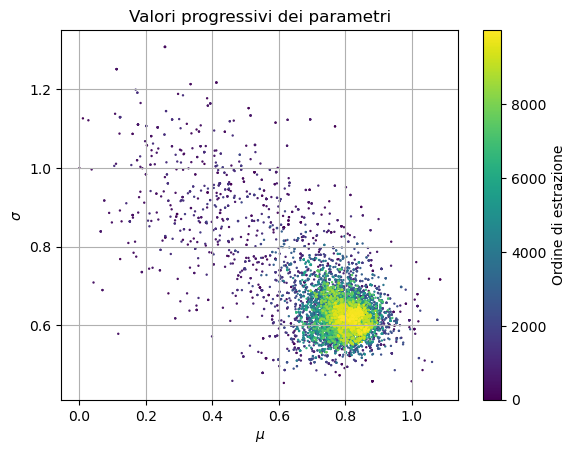

In [315]:
plt.scatter(mus, sigmas, c=list(range(len(mus))), cmap="viridis", s=0.5)
plt.xlabel(r"$\mu$")
plt.ylabel(r"$\sigma$")
plt.colorbar(label="Ordine di estrazione")
plt.title("Valori progressivi dei parametri")
plt.grid()

In [316]:
energies = []
errors = []
for step in range(1, 101):
    filename = "optimizationData/energies_step" + str(step) + ".dat"
    with open(filename) as f:
        f.readline() #Skip 1st row
        for line in f:
            energy, error, __ = map(float, line.strip().split())
        energies.append(energy)
        errors.append(error)

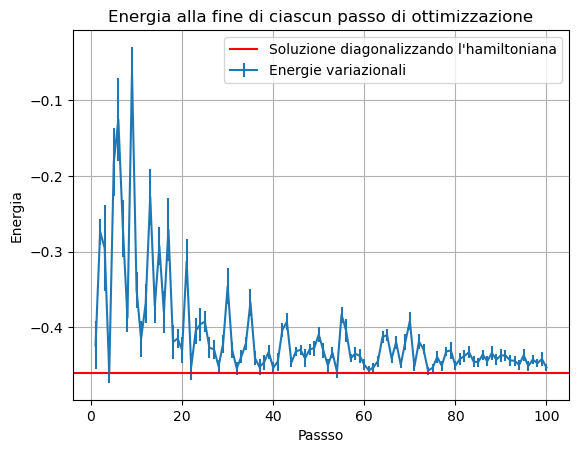

In [317]:
plt.errorbar(list(range(1, 101)), energies, yerr=errors, label = "Energie variazionali")
plt.title("Energia alla fine di ciascun passo di ottimizzazione")
plt.xlabel("Passso")
plt.ylabel("Energia")
plt.axhline(-0.460465879692715, color="red", label="Soluzione diagonalizzando l'hamiltoniana")
plt.legend()
plt.grid()

Dai grafici vediamo il comportamento che ci asppettiamo: all'inizio i valori dei parametri generati coprono un'area relativamente larga, che diventa sempre più stretta man mano che la temperatura si abbassa. Il valore corrispondente dell'energia diventa sempre meno variabile man mano che si prosegue nell'ottimizzazione e la stima dei parametri diventa migliore.

### Campionamento finale

Alla fine del percorso di ottimizzazione ccampioniamo la distribuzione data dalla funzione d'onda e alcoliamo l'energia un'ultima volta, usando gli ultimi valori dei parametri e $150$ blocchi. Carico i valori della distribuzione e dell'energia:

In [318]:
distro = []
with open("final_distro.dat") as f:
    __, mu = f.readline().strip().split()
    __, sigma = f.readline().strip().split()
    __, n_blocks= f.readline().strip().split()
    __, pts_per_block= f.readline().strip().split()
    for line in f:
        d = float(line.strip())
        distro.append(d)

mu, sigma, n_blocks, pts_per_block = map(float, [mu, sigma, n_blocks, pts_per_block])
len(distro)

15000

In [319]:
mu, sigma, n_blocks, pts_per_block

(0.795637, 0.614313, 150.0, 100.0)

In [320]:
means, errors = np.loadtxt("final_energy.dat", skiprows=1, unpack=True)

Disegno il grafico dell'energia:

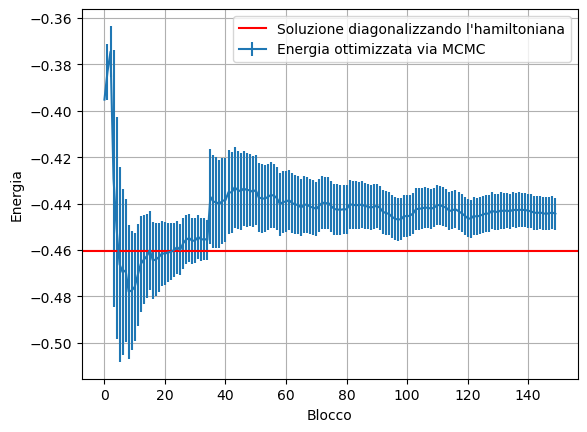

In [321]:
xs = np.arange(len(means))
plt.errorbar(xs, means, yerr = errors, label="Energia ottimizzata via MCMC")
plt.axhline(-0.460465879692715, color="red", label="Soluzione diagonalizzando l'hamiltoniana")
plt.grid(True)
plt.xlabel("Blocco")
plt.ylabel("Energia")
plt.legend()

Ricopio la casella per il calcolo dell'energia dello stato fondamentale tramite la diagonalizzazione di una versione discretizzata dell'hamiltoniana:

In [322]:
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

Ground state energy:  -0.460465879692715
1st excited state energy:  0.0974247133176097
2nd excited state energy:  1.9717331343930198


Disegno il grafico della distribuzione finale data da $|\psi|^2$ (quella analitica calcolata con i valori finali di $\mu$ e $\sigma$ e quella ottenita con il campionamento per il calcolo finale dell'energia) e lo confronto con la distribuzione data dalla diagonalizzazione dell'haniltoniana:

In [323]:
norm = 2*np.sqrt(np.pi)*sigma*(1+np.exp(-(mu/sigma)**2))

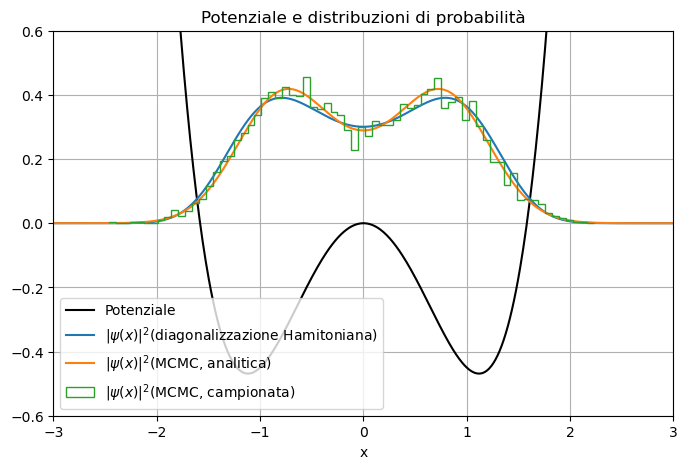

In [324]:
# Plot a few things
plt.figure(figsize=(8,5))
scale = 0.3
plt.plot(x, scale*V, color="Black", label="Potenziale") # plot the potential
plt.plot(x,(psi[0])**2, label=r"$|\psi(x)|^2$"+"(diagonalizzazione Hamitoniana)")
plt.plot(x, psi2(x, mus[-1], sigmas[-1])/norm, label=r"$|\psi(x)|^2$"+"(MCMC, analitica)")
plt.hist(distro, bins=70, density=True, histtype="step", label=r"$|\psi(x)|^2$"+"(MCMC, campionata)")
plt.plot()
#plt.plot(x,(psi[1])**2)
#plt.plot(x,(psi[2])**2)
plt.title("Potenziale e distribuzioni di probabilità")
plt.xlabel("x")
plt.grid(True)
plt.xlim((-3,3))
plt.ylim((-0.6,0.6))
plt.legend()
plt.show()

Vediamo che sia l'energia che la distribuzione finale si confrontano discretamente ma non benissimo con i corrispondenti risultati otenuti via la diagonalizzazione dell'Hamiltoniana: la discrepanza può essere attribuita alla limitata capacità rappresentativa dell'_ansaz_ che abbiamo usato per la funzione d'onda.